In [70]:
!pip install optuna


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [146]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import optuna

In [ ]:
data = pd.read_csv("elb_request_count_8c0756.csv")

numeric_cols = data.select_dtypes(include=[np.number])

#Removal of outliers
data_clean = data[(np.abs(stats.zscore(numeric_cols)) < 3).all(axis=1)]

print(f"Before: {len(data)} lines")
print(f"After: {len(data_clean)} lines")

Before: 4032 lines
After: 3969 lines


AttributeError: 'str' object has no attribute 'mean'

In [147]:
scaler = MinMaxScaler()

value_col = data_clean[[data_clean.columns[1]]].astype(float)
print(f"mean: {value_col.mean()}")

X_scaled = scaler.fit_transform(value_col)

mean: value    58.381204
dtype: float64


In [148]:
def create_autoencoder(trial):

    input_dim = X_scaled.shape[1]
    encoding_dim = trial.suggest_int("encoding_dim", 4, 64)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    input_layer = keras.Input(shape=(input_dim,))

    encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)
    decoded = layers.Dense(input_dim, activation="linear")(encoded)

    autoencoder = keras.Model(input_layer, decoded)

    autoencoder.compile(optimizer=Adam(learning_rate=lr), loss="mse")

    history = autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=batch_size, validation_split=0.1, verbose=0)

    val_loss = min(history.history['val_loss'])
    return val_loss

In [149]:
study = optuna.create_study(direction="minimize")
study.optimize(create_autoencoder, n_trials=10)  # 30 tentativas, pode aumentar

[I 2025-10-25 20:49:58,960] A new study created in memory with name: no-name-d659b65c-5f4b-4d77-857e-53a78cb699b3
[I 2025-10-25 20:50:10,175] Trial 0 finished with value: 1.0756870324257761e-05 and parameters: {'encoding_dim': 22, 'learning_rate': 0.00012948530856854464, 'batch_size': 32}. Best is trial 0 with value: 1.0756870324257761e-05.
[I 2025-10-25 20:50:28,629] Trial 1 finished with value: 2.9040337842789476e-11 and parameters: {'encoding_dim': 63, 'learning_rate': 0.005853982716624654, 'batch_size': 16}. Best is trial 1 with value: 2.9040337842789476e-11.
[I 2025-10-25 20:50:40,215] Trial 2 finished with value: 3.376363508778013e-07 and parameters: {'encoding_dim': 43, 'learning_rate': 0.00031761385831772674, 'batch_size': 32}. Best is trial 1 with value: 2.9040337842789476e-11.
[I 2025-10-25 20:50:57,277] Trial 3 finished with value: 9.604458028888985e-08 and parameters: {'encoding_dim': 15, 'learning_rate': 0.0002454392844922473, 'batch_size': 16}. Best is trial 1 with value:

In [150]:
print("best hyperparameters:", study.best_params)
print("best validation loss:", study.best_value)

best hyperparameters: {'encoding_dim': 4, 'learning_rate': 0.008025962269698712, 'batch_size': 64}
best validation loss: 5.77619242363934e-16


In [151]:
best_params = study.best_params

autoencoder_final = Sequential([
    Dense(best_params['encoding_dim'], activation='relu', input_shape=(X_scaled.shape[1],)),
    Dense(X_scaled.shape[1], activation='linear')
])

autoencoder_final.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                          loss='mse')

autoencoder_final.fit(X_scaled, X_scaled, epochs=50, batch_size=best_params['batch_size'], validation_split=0.1)

Epoch 1/50


c:\Users\pedro\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1315 - val_loss: 0.0732
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0510 - val_loss: 0.0581
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0459 - val_loss: 0.0559
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0452 - val_loss: 0.0556
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 - val_loss: 0.0557
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 - val_loss: 0.0561
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0451 - val_loss: 0.0552
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0451 - val_loss: 0.0553
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0451 - val_loss: 0.0564
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0451 - val_loss: 0.0567
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0451 - val_loss: 0.0558
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0452 - val_loss: 0.0554


In [152]:
reconstructions = autoencoder_final.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step


In [161]:
threshold = np.percentile(mse, 80)
print("Threshold:", threshold)

Threshold: 0.05409225541695953


In [162]:
anomalies = mse > threshold
data_clean["anomaly"] = anomalies

C:\Users\pedro\AppData\Local\Temp\ipykernel_10272\2683917128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean["anomaly"] = anomalies


In [163]:
print(data_clean[data_clean["anomaly"] == True])
print(data_clean[data_clean["anomaly"] == True].count())

                timestamp  value  anomaly
2     2014-04-10 00:14:00  187.0     True
15    2014-04-10 01:19:00  139.0     True
18    2014-04-10 01:34:00  124.0     True
22    2014-04-10 01:54:00  115.0     True
29    2014-04-10 02:29:00  119.0     True
...                   ...    ...      ...
4001  2014-04-23 22:09:00  209.0     True
4003  2014-04-23 22:19:00  164.0     True
4017  2014-04-23 23:29:00  115.0     True
4023  2014-04-23 23:59:00  182.0     True
4026  2014-04-24 00:14:00    4.0     True

[766 rows x 3 columns]
timestamp    766
value        766
anomaly      766
dtype: int64


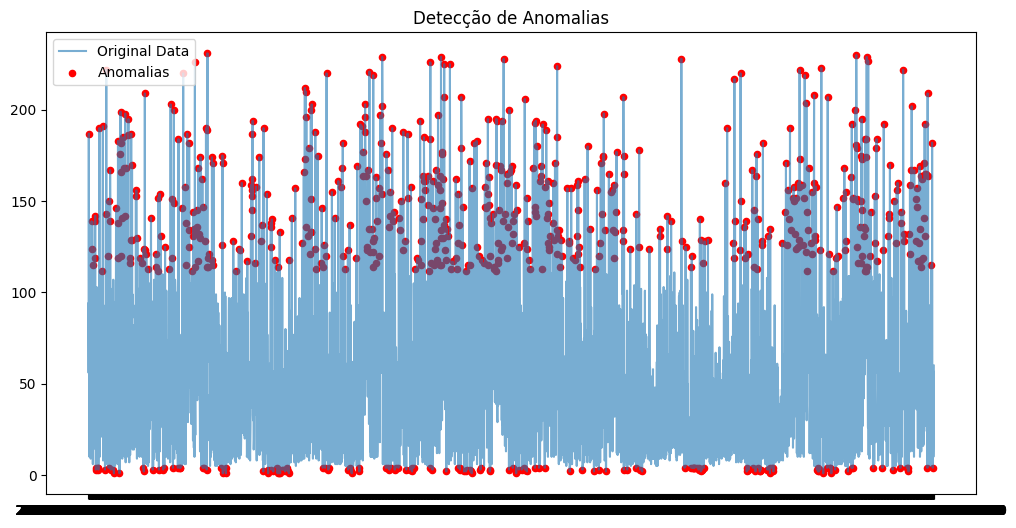

In [164]:
plt.figure(figsize=(12,6))
plt.plot(data_clean['timestamp'], data_clean['value'], label='Original Data', alpha=0.6)
plt.scatter(
    data_clean.loc[data_clean['anomaly'], 'timestamp'],
    data_clean.loc[data_clean['anomaly'], 'value'],
    color='red', label='Anomalias', s=20
)
plt.legend()
plt.title("Detecção de Anomalias")
plt.show()

In [165]:
# Proporção de anomalias detectadas
print(f"Porcentagem de anomalias: {data_clean['anomaly'].mean() * 100:.2f}%")

Porcentagem de anomalias: 19.30%
